# Bitcoin DCA strategies comparison

1. is there any dca strategy which overperforms the others?
2. is there anything else that can be done on top of the dca?

In [75]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import ipywidgets as widgets
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
os.getcwd()

'/Users/alinemartinscs/Documents/GitHub/btc-dca'

In [93]:
def executeDCA(data, start_date, purchase_freq_days, buy_contr):
    
    #dca_active mask tells the period in which the strategy is being executed
    data['dca_active'] = data['Time'] >= start_date

    #dca_days - how many days the strategy is being executed   
    data['dca_days'] = False
    mask = (data['dca_active'] == True)
    data['dca_days'].loc[mask] = range(1,mask.sum()+1)   

    # a trigger indicating buy moments
    data['dca_buy_trigger'] = data['dca_active'] & (data['dca_days'] % purchase_freq_days == 1)

    # calculate accums
    data['purchase_btc'] = buy_contr / data['price_usd'] * data['dca_buy_trigger']        
    data['purchase_usd'] = buy_contr * data['dca_buy_trigger']    
    data['accum_invested_usd'] = data['purchase_usd'].cumsum()
    data['accum_btc'] = data['purchase_btc'].cumsum()
    data['portfolio_value_usd'] = data['accum_btc'] * data['price_usd']  
    data['gains_perc'] = data['portfolio_value_usd'] / data['accum_invested_usd'] * 100
    
    out_metrics = {}
    out_metrics['start_date'] = start_date
    out_metrics['total_days'] = int(data.dca_days.tail(1))
    out_metrics['total_invested_usd'] = float(data.accum_invested_usd.tail(1))
    out_metrics['net_worth'] = float(data.portfolio_value_usd.tail(1))
    out_metrics['gains_perc'] = float(data.gains_perc.tail(1))
    #out_metrics = pd.DataFrame(out_metrics)
    
    
    return out_metrics


In [94]:
def plotGains(strategies, total_days):
    
    
    fig, (ax1, ax2) = plt.subplots(2,figsize=(20,15))
    
    df1 = pd.DataFrame()
    df1['price_usd'] = strategies.price_usd
    df1['accum_invested_usd'] = strategies.accum_invested_usd
    df1['portfolio_value_usd'] = strategies.portfolio_value_usd
    df1 = df1.set_index(strategies.Time)
    ax1.plot(df1.tail(total_days))
    ax1.set_title('Values')
    ax1.set(ylabel='USD')

    df2 = pd.DataFrame()
    df2['gains_perc'] = strategies.gains_perc
    df2 = df2.set_index(strategies.Time)
    ax2.plot(df2.tail(total_days))
    ax2.set_title('Gains')
    ax2.set(ylabel='Percentage (%)')

    plt.gcf().autofmt_xdate()    
    plt.show()

In [95]:
data = pd.DataFrame(pd.read_csv("btcdata.csv", sep='\t'))
data.columns

Index(['Time', 'BTC / USD Denominated Closing Price',
       'BTC / MVRV (Market Cap / Realized Market Cap)',
       'BTC / 30 Day Volatility', 'BTC / 180 Day Volatility'],
      dtype='object')

In [96]:
data.Time = pd.to_datetime(data.Time)
data.rename(columns={'BTC / USD Denominated Closing Price': 'price_usd'}, inplace=True)
data.rename(columns={'BTC / MVRV (Market Cap / Realized Market Cap)': 'ratio_mktcap_realizedmktcap'}, inplace=True)
data.rename(columns={'BTC / 30 Day Volatility': '30_day_volatility'}, inplace=True)
data.rename(columns={'BTC / 180 Day Volatility': '180_day_volatility'}, inplace=True)
data.columns

Index(['Time', 'price_usd', 'ratio_mktcap_realizedmktcap', '30_day_volatility',
       '180_day_volatility'],
      dtype='object')

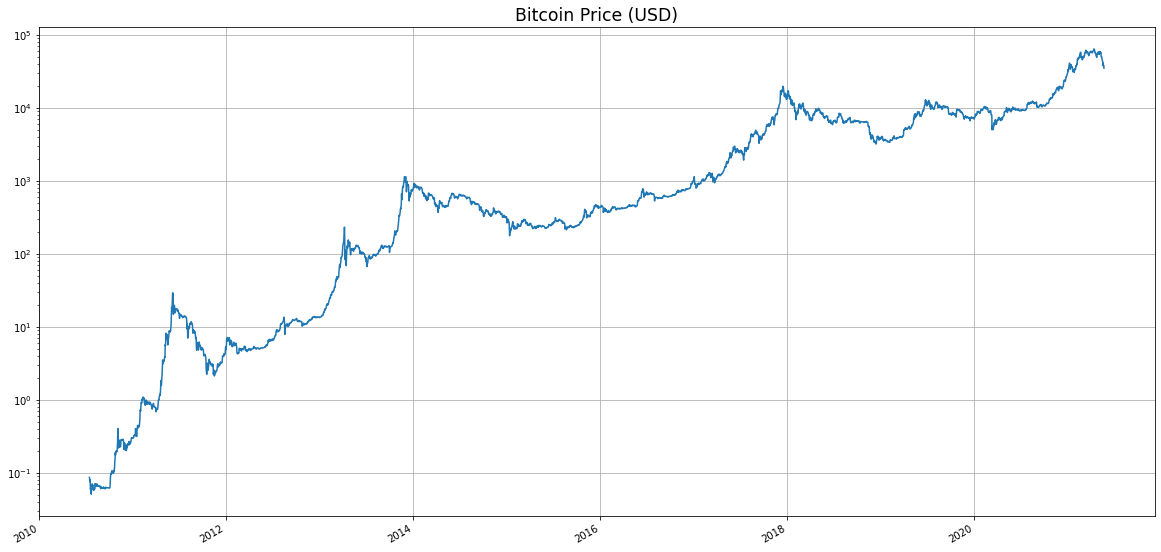

In [97]:
# plot btc usd price
fig = plt.figure(figsize=(20, 10))
df = pd.DataFrame()
df['value'] = data.price_usd
df = df.set_index(data.Time)
plt.plot(df)
plt.gcf().autofmt_xdate()
plt.title('Bitcoin Price (USD)', fontsize='xx-large')
plt.yscale('log')
plt.grid()
#plt.show()


In [126]:
def plotStrategies(one_off_strategies, simple_dca_strategies={}):
    fig1,ax = plt.subplots()
    num_data_points_plot = 1600

    # Plot BTC price in primary axis
    df = pd.DataFrame()
    df['btc_price'] = data.price_usd
    df = df.set_index(data.Time)
    ax.plot(df.tail(num_data_points_plot),'k', label='btc_price_usd')
    plt.legend(loc='best')
    ax.set_ylabel("BTC Price (USD)",fontsize=10)

    # Plot strategies (BTC accumulated) in secondary axis
    num_strategies = len(one_off_strategies['start_date'])
    df = pd.DataFrame()
    ax2 = ax.twinx()
    date_str = []
    for i in range(num_strategies):
        date_str.append('One-off in '+ str(one_off_strategies['out_metrics']['start_date'][i]).split(' ')[0])
        df[date_str[i]] = one_off_strategies['data'][i]['accum_btc']
    df = df.set_index(data.Time)
    ax2.plot(df.tail(num_data_points_plot), label=date_str)
    plt.legend(loc='center left')

    ax2.set_ylabel("Accumulated BTCs",fontsize=10)
    ax2.set_ylim([0,10])

    plt.gcf().autofmt_xdate()
    plt.gcf().set_size_inches(15, 10)
    plt.grid()
    plt.show()
    
    
    # Plot DCA strategies    
    if simple_dca_strategies != {}:
        num_strategies = len(simple_dca_strategies['start_date'])
        df = pd.DataFrame()
        #ax3 = ax.twinx()
        date_str = []
        for i in range(num_strategies):
            date_str.append('Monthly DCA starting '+ str(simple_dca_strategies['out_metrics']['start_date'][i]).split(' ')[0])
            df[date_str[i]] = simple_dca_strategies['data'][i]['accum_btc']
        df = df.set_index(data.Time)
        ax2.plot(df.tail(num_data_points_plot), label=date_str)
        plt.legend(loc='center left')
        plt.show()


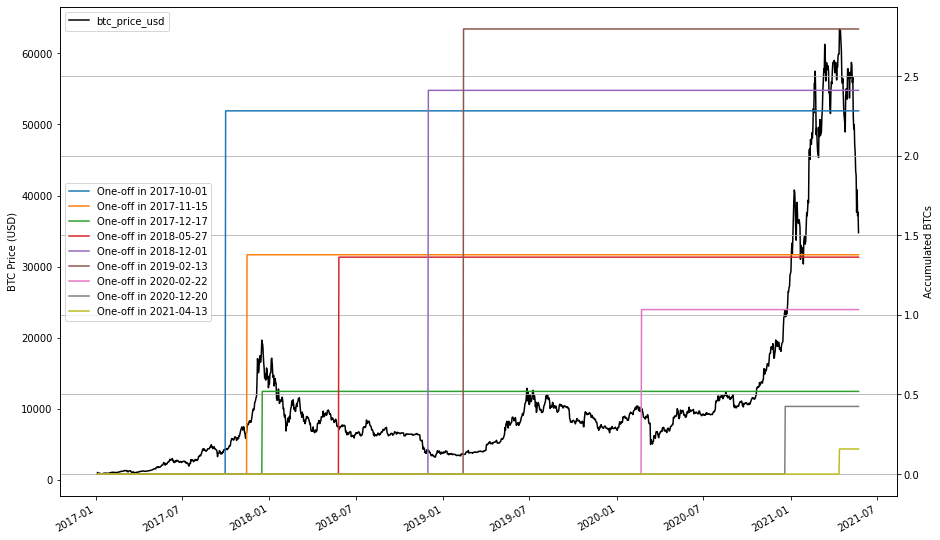

In [99]:
# Strategy: one-off buys 

total_contrib_usd = 10000

# Define the strategies parameters
one_off_strategies = {}
one_off_strategies['start_date'] = pd.to_datetime(['2017/10/01', '2017/11/15', '2017/12/17', '2018/5/27', '2018/12/1', '2019/02/13', '2020/02/22', '2020/12/20', '2021/04/13'])
num_strategies = len(one_off_strategies['start_date'])
one_off_strategies['purchase_freq_days'] = [999999] * num_strategies
one_off_strategies['buy_contr_usd'] = [total_contrib_usd] * num_strategies
one_off_strategies['data'] = [data] * num_strategies
one_off_strategies['out_metrics'] = {}

# Execute the strategy
for i in range(num_strategies):  
    one_off_strategies['data'][i] = data.copy()
    one_off_strategies['out_metrics'][i] = executeDCA(one_off_strategies['data'][i], 
                                                      one_off_strategies['start_date'][i], 
                                                      one_off_strategies['purchase_freq_days'][i], 
                                                      one_off_strategies['buy_contr_usd'][i])
one_off_strategies['out_metrics'] = (pd.DataFrame(one_off_strategies['out_metrics'])).T

plotStrategies(one_off_strategies)

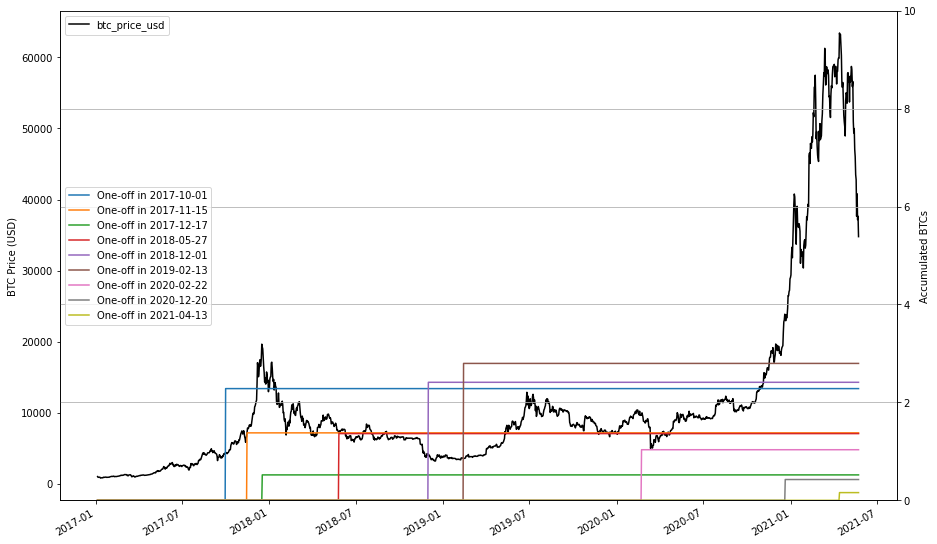

No handles with labels found to put in legend.


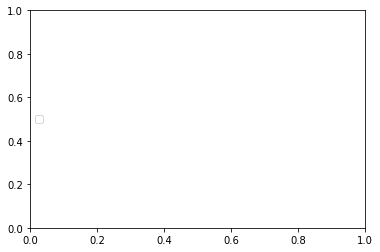

In [129]:
# Strategy: monthly DCA 

total_contrib_usd = 10000
purchase_freq_days = 60

# Define the strategies parameters
simple_dca_strategies = {}
simple_dca_strategies['start_date'] = one_off_strategies['start_date']
num_strategies = len(simple_dca_strategies['start_date'])
len_strategies_days = (pd.to_datetime(list(data.Time.tail(1)) * num_strategies) - simple_dca_strategies['start_date']).days.values + 1
simple_dca_strategies['purchase_freq_days'] = [purchase_freq_days] * num_strategies
simple_dca_strategies['buy_contr_usd'] = total_contrib_usd / len_strategies_days * simple_dca_strategies['purchase_freq_days']
simple_dca_strategies['data'] = [data] * num_strategies
simple_dca_strategies['out_metrics'] = {}

# Execute the strategy
for i in range(num_strategies):  
    simple_dca_strategies['data'][i] = data.copy()
    simple_dca_strategies['out_metrics'][i] = executeDCA(simple_dca_strategies['data'][i], 
                                                         simple_dca_strategies['start_date'][i], 
                                                         simple_dca_strategies['purchase_freq_days'][i], 
                                                         simple_dca_strategies['buy_contr_usd'][i])
simple_dca_strategies['out_metrics'] = (pd.DataFrame(simple_dca_strategies['out_metrics'])).T

monthly_dca = simple_dca_strategies.copy()

plotStrategies(one_off_strategies, monthly_dca)

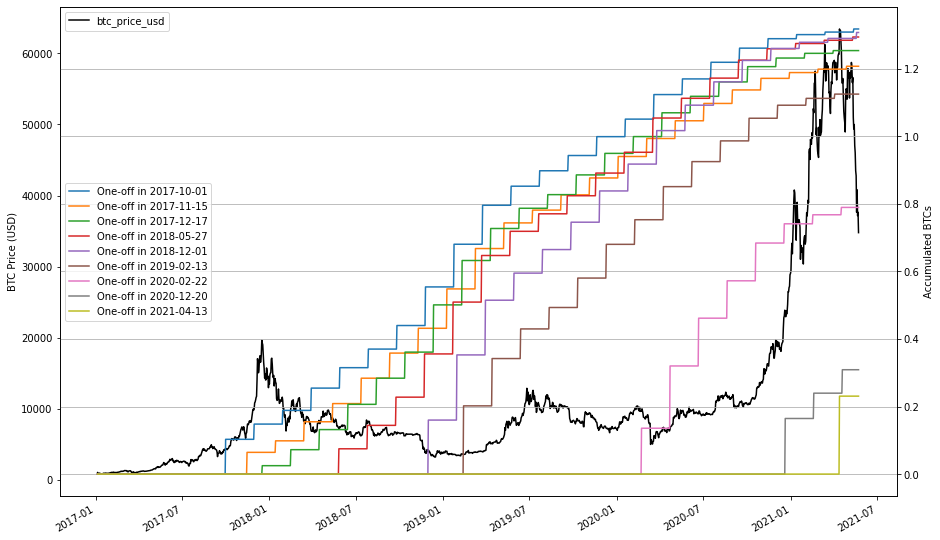

No handles with labels found to put in legend.


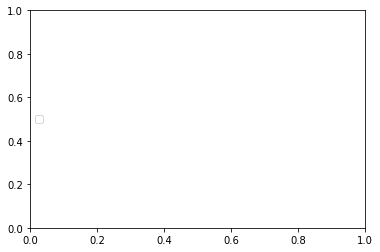

In [101]:
# Strategy: monthly DCA 

purchase_freq_days = 7

simple_dca_strategies['purchase_freq_days'] = [purchase_freq_days] * num_strategies
simple_dca_strategies['buy_contr_usd'] = total_contrib_usd / len_strategies_days * simple_dca_strategies['purchase_freq_days']
simple_dca_strategies['data'] = [data] * num_strategies
simple_dca_strategies['out_metrics'] = {}

# Execute the strategy
for i in range(num_strategies):  
    simple_dca_strategies['data'][i] = data.copy()
    simple_dca_strategies['out_metrics'][i] = executeDCA(simple_dca_strategies['data'][i], 
                                                         simple_dca_strategies['start_date'][i], 
                                                         simple_dca_strategies['purchase_freq_days'][i], 
                                                         simple_dca_strategies['buy_contr_usd'][i])
simple_dca_strategies['out_metrics'] = (pd.DataFrame(simple_dca_strategies['out_metrics'])).T

weekly_dca = simple_dca_strategies.copy()

plotStrategies(monthly_dca, weekly_dca)

In [102]:
# import ipywidgets.interact class, this class will represent a slide bar.
from ipywidgets import interact

t = range(0,100)

# use interact decorator to decorate the function, so the function can receive the slide bar's value with parameter x.
@interact(x=(0, 100))
def double_number(x):
    print("The double of %d is %d." % (x, x*2))
    
# add another slide bar to this function with the interact decorator.    
@interact(y=(0, 10))
def square_number(y):
    print("The square of %d is %d." % (y, y**2))

interactive(children=(IntSlider(value=50, description='x'), Output()), _dom_classes=('widget-interact',))

interactive(children=(IntSlider(value=5, description='y', max=10), Output()), _dom_classes=('widget-interact',…

In [103]:
dados = {}
dados['t']= np.arange(0.0,2*np.pi, 0.1)
dados['y']= np.sin(dados['t'])
df = pd.DataFrame(dados)

def g(w):
    df['y'] = np.sin(w * df['t'])
    plt.scatter(df['t'], df['y'])
    plt.show()

interactive_plot = interactive(g, w=1.0)
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='w', max=3.0, min=-1.0), Output()), _dom_classes=('wi…

In [128]:
start_day_init = 2400

def visualize_dca(start_day=start_day_init):
    # Strategy: one-off buys 
    start_date = data.Time[start_day]

    total_contrib_usd = 10000

    # Define the strategies parameters
    one_off_strategies = {}
    one_off_strategies['start_date'] = [start_date]
    num_strategies = len(one_off_strategies['start_date'])
    one_off_strategies['purchase_freq_days'] = [999999] * num_strategies
    one_off_strategies['buy_contr_usd'] = [total_contrib_usd] * num_strategies
    one_off_strategies['data'] = [data] * num_strategies
    one_off_strategies['out_metrics'] = {}

    # Execute the strategy
    for i in range(num_strategies):  
        one_off_strategies['data'][i] = data.copy()
        one_off_strategies['out_metrics'][i] = executeDCA(one_off_strategies['data'][i], 
                                                          one_off_strategies['start_date'][i], 
                                                          one_off_strategies['purchase_freq_days'][i], 
                                                          one_off_strategies['buy_contr_usd'][i])
    one_off_strategies['out_metrics'] = (pd.DataFrame(one_off_strategies['out_metrics'])).T


    total_contrib_usd = 10000
    purchase_freq_days = 60

    # Define the strategies parameters
    simple_dca_strategies = {}
    simple_dca_strategies['start_date'] = one_off_strategies['start_date']
    num_strategies = len(simple_dca_strategies['start_date'])
    len_strategies_days = (pd.to_datetime(list(data.Time.tail(1)) * num_strategies) - simple_dca_strategies['start_date']).days.values + 1
    simple_dca_strategies['purchase_freq_days'] = [purchase_freq_days] * num_strategies
    simple_dca_strategies['buy_contr_usd'] = total_contrib_usd / len_strategies_days * simple_dca_strategies['purchase_freq_days']
    simple_dca_strategies['data'] = [data] * num_strategies
    simple_dca_strategies['out_metrics'] = {}

    # Execute the strategy
    for i in range(num_strategies):  
        simple_dca_strategies['data'][i] = data.copy()
        simple_dca_strategies['out_metrics'][i] = executeDCA(simple_dca_strategies['data'][i], 
                                                             simple_dca_strategies['start_date'][i], 
                                                             simple_dca_strategies['purchase_freq_days'][i], 
                                                             simple_dca_strategies['buy_contr_usd'][i])
    simple_dca_strategies['out_metrics'] = (pd.DataFrame(simple_dca_strategies['out_metrics'])).T

    monthly_dca = simple_dca_strategies.copy()

    plotStrategies(one_off_strategies, monthly_dca)


interactive_plot = interactive(visualize_dca, start_day=(start_day_init,len(data.Time) - 1))
interactive_plot

interactive(children=(IntSlider(value=2400, description='start_day', max=3962, min=2400), Output()), _dom_clas…